### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [41]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [42]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 30000 
P.modelmaxtri = 30000 # 10000 for ref
P.angle = 34   # minimum triangle angles

P.radius1 = 0 # radius of inner circle around pumping bores
P.radius2 = 120 # radius of outer circle around pumping bores
P.boremaxtri = 100000

#P.geo_bores = ['P1', 'P2', 'P3', 'P4']
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 4 # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)
P.res = 2 # vertical resolution upon which voxel grid created to pick lithology bottoms

P.hk = [1.7, 0.07, 8.2, 0.05] 
P.vk = [0.12,0.003,0.51,0.005]
P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = 0.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.1)] # period length, number of timesteps, tsmult
P.qwell_past = -2000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.1)] # period length, number of timesteps, tsmult
P.qwell_future = -5000 #m3/d 

#P.zobs = [-50, -100, -200]
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(workspace, exist_ok=True)
    
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
    
    
P.min_modlay_thick = [20, 50, 100, 200]

### 2. Meshing

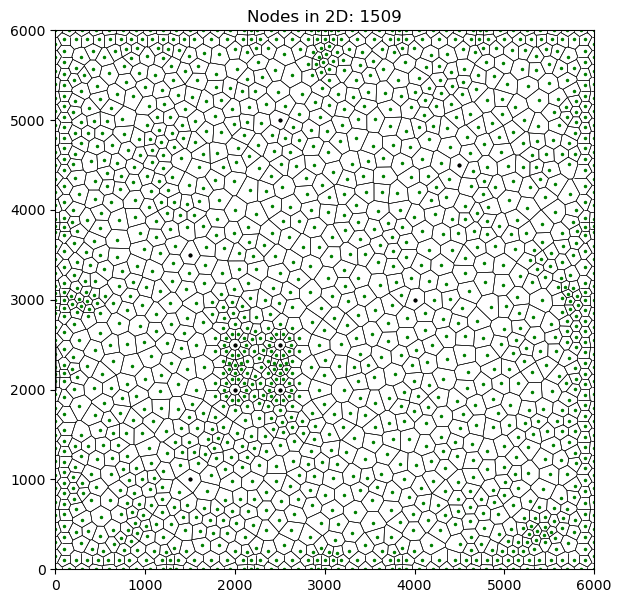

In [43]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

In [44]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

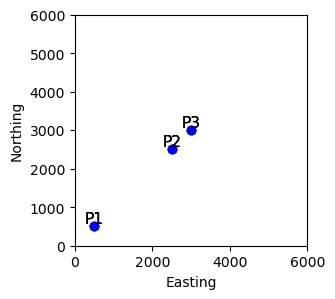

In [45]:
P.data
P.geomodel.feature_names()
plot_bores(P)

### 4. Flow model (Reference)

In [46]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb

# Initiate REFERENCE
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

loop2flopy routines loaded!
   Creating lithology and discretisation arrays for  ref  ...


In [47]:
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print('Well coords ', wel_coords, ' Well screen top and bottom ', wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))
    
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        if m == 0:
            lay_top = R.top[obs_icpl]  
        else:   
            lay_top = R.botm[(m)* P.nls-1, obs_icpl]
        lay_bot = R.botm[(m + 1) * P.nls-1, obs_icpl]   
        obsz = lay_bot + (lay_top-lay_bot)/2
        P.zobs[n][m] = obsz
print('\nobservation depths')
print(P.zobs)

Well coords  (2000.0, 2000.0)  Well screen top and bottom  -186.0 -288.0
Well coords  (2500.0, 2000.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2000.0, 2500.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2500.0, 2500.0)  Well screen top and bottom  -148.0 -250.0

observation depths
[[ -25. -162. -326.]
 [ -25.  -50. -101.]
 [ -25.  -60. -121.]
 [ -25.  -99. -199.]
 [ -25.  -50.  -73.]]


In [48]:
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

   Creating property arrays for  ref  ...
   Adding flow packages to  ref  ...
   Time taken =  0.93369
ref  has  24144  nodes.


In [49]:
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = R.write_run_model(P, period = 'Steady', ic_array = P.strt)   # 3 hours to run!

   Writing simulation and gwf for  ref  ...
Period =  Steady 
   Model success =  True
   run_time =  30.286989


In [50]:
R.gwf, R.head_present, R.obs_present, R.runtime_past = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)

   Writing simulation and gwf for  ref  ...
Period =  Past 
   Model success =  True
   run_time =  77.203661


In [51]:
R.gwf, R.head_future, R.obs_future, R.runtime_future = R.write_run_model(P, period = 'Future', ic_array = R.head_present)

   Writing simulation and gwf for  ref  ...
Period =  Future 
   Model success =  True
   run_time =  162.842993


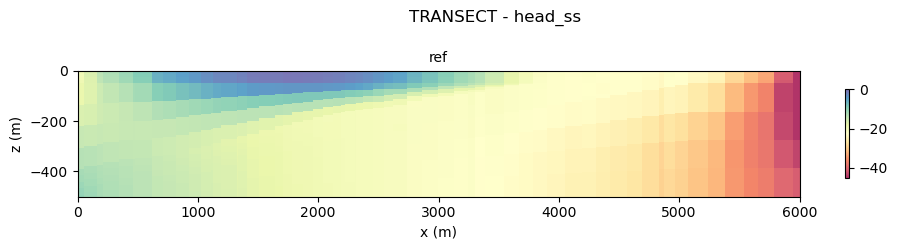

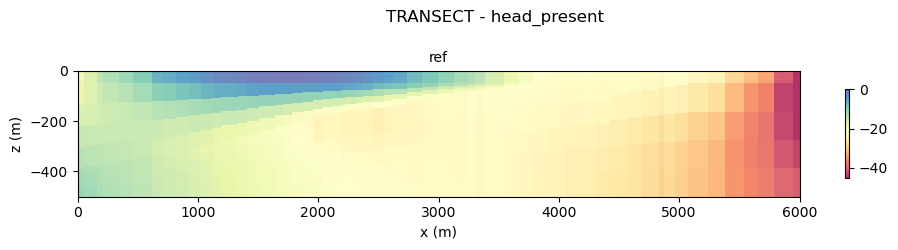

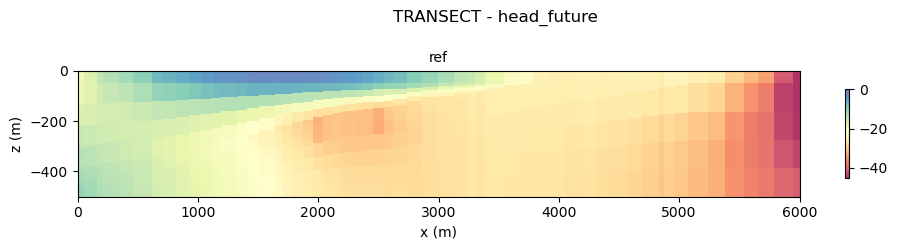

In [52]:
multiplot_prop_transect(P, models = [R], array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_future', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, 
                        vmin = -45, vmax = 0)

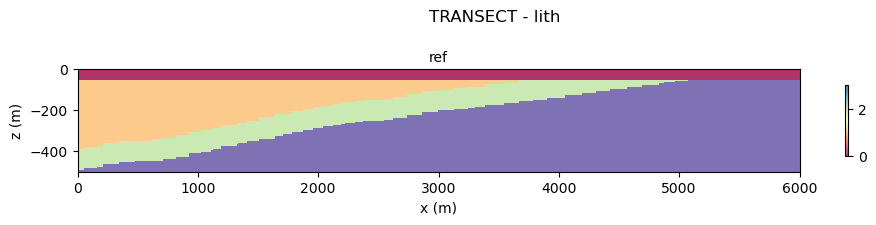

In [53]:
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

In [54]:
#f = os.path.join(vtk_workspace, "test", R.modelname)
#R.gwf.export(f, fmt="vtk")

In [55]:
#plot_flow_features(P, [R])
#multiplot_prop_transect(P, models = [R], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

In [56]:
#y_ = [1000,1500,2000,2500,3000,4000,5000]
#for y in y_:
#    multiplot_prop_transect(P, models=[R], array ='head_future',X0=P.x0, Y0=y, X1=P.x1, Y1=y, vmin = -45, vmax = 0)

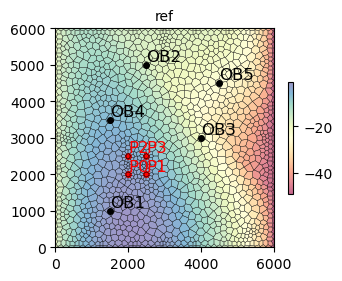

In [57]:
plot_bylayer(P, models = [R], layer = 1)#, vmin = -20, vmax = 5) 

In [58]:
#multiplot_prop_plan(P, models = [R], array = 'k11', layer = 3)#, vmin = None, vmax = None):   # array needs to be a string of a property eg. 'k11', 'logk11'  


### Testing convergence

In [59]:
# 0.27972511989404736 -1.9442518204215036 0.38322898929495725 -1.2905279279633497 -0.5824396583949223 -2.4754872268614063 -0.3344909931386087 -2.6400478413900395 -4.517405710106817 -4.610738280002378 -4.712335701038782 0.11386417979259696 -160.4664408080099
   

In [61]:
loghk0, loghk1, loghk2, loghk3 = 0.27972511989404736, -1.9442518204215036, 0.38322898929495725, -1.2905279279633497
logvk0, logvk1, logvk2, logvk3 =  -0.5824396583949223, -2.4754872268614063, -0.3344909931386087, -2.640047841390039
logss1, logss2, logss3 = -4.517405710106817, -4.610738280002378, -4.712335701038782
sy0 =  0.11386417979259696
cp =  -160.4664408080099

P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3]
P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3]
P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
P.sy = [sy0, 0.1, 0.1, 0.1]

In [62]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
# Initiate TEST
P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False)
T = Model('test', P, plan = 'vor', transect = 'con') 
T.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
T.create_prop_arrays(P)         # Create property arrays (NPF)
T.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(T.modelname, ' has ', T.ncell_disu, ' nodes.')

T.gwf, T.head_ss, T.obs_ss, T.runtime_ss = T.write_run_model(P, period = 'Steady', ic_array = P.strt) 
T.gwf, T.head_present, T.obs_present, T.runtime_past = T.write_run_model(P, period = 'Past', ic_array = T.head_ss)
T.gwf, T.head_future, T.obs_future, T.runtime_future = T.write_run_model(P, period = 'Future', ic_array = T.head_present)

loop2flopy routines loaded!
   Creating lithology and discretisation arrays for  test  ...
   Creating property arrays for  test  ...
   Adding flow packages to  test  ...
   Time taken =  1.268657
test  has  20744  nodes.
   Writing simulation and gwf for  test  ...
Period =  Steady 
   Model success =  True
   run_time =  26.261569
   Writing simulation and gwf for  test  ...
Period =  Past 
   Model success =  True
   run_time =  85.610794
   Writing simulation and gwf for  test  ...
Period =  Future 
   Model success =  True
   run_time =  209.879455


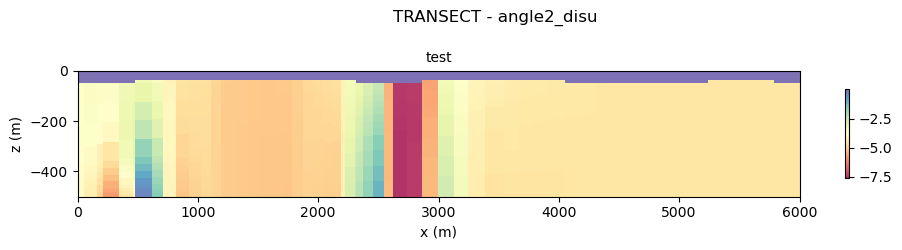

In [63]:
T.angle2_disu = T.gwf.npf.angle2.array

multiplot_prop_transect(P, models = [T], array = 'angle2_disu', X0=P.x0, Y0=P.y0, X1=P.x1, Y1=P.y1)

In [64]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
gwf = sim.get_model('test')


loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disu...
    loading package npf...
    loading package ic...
    loading package sto...
    loading package wel...
    loading package chd...
    loading package rch...
    loading package obs...
    loading package oc...
  loading ims package test...


In [65]:
def plot_problem_cell(P, gwf, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    a = gwf.npf.k.get_data()
    fig = plt.figure(figsize = (10,3))
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i" %(Y))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i" %(X))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(X, P.y0),(X, P.y1)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    #ax.set_xlim([1000, 3000])
    #ax.set_ylim([-68, -48])
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.set_title("Plan")
    mapview = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, layer = 0)#, geographic_coords=True)
    plan = mapview.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Y, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('y (m)', size = 10)
    linecollection = mapview.plot_grid(lw = 0.1, color = 'black') 
    
    #plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  

minimum cell thickness = 0.500000 at node 12
XYZ problem =  5176.933102466725 2688.9895651687216 -18.75
cell width approx  211.4092523508125
cell length approx  185.51535840673205
cell thickness 12.5


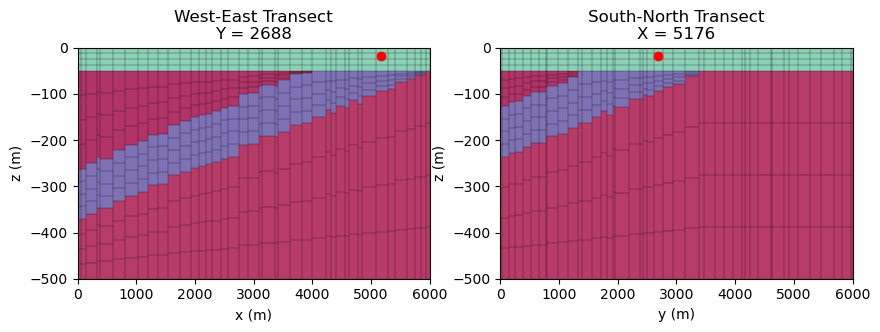

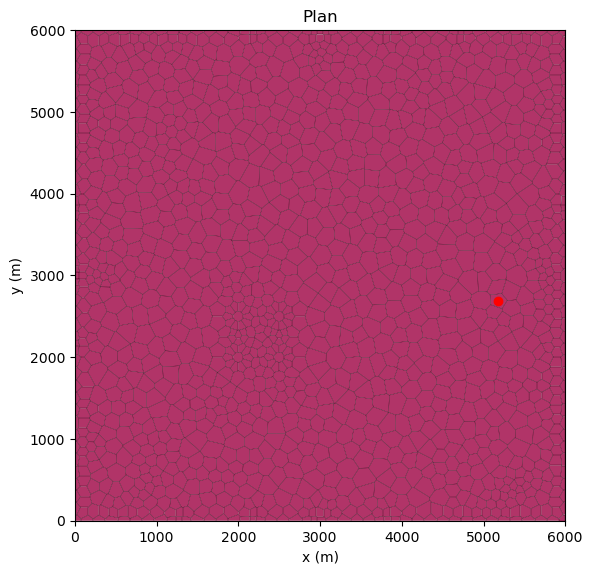

In [66]:
node = 2731-1

print("minimum cell thickness = %f at node %i" %(T.gwf.modelgrid.thick.min(), T.gwf.modelgrid.thick[node]))

X = T.gwf.modelgrid.xyzcellcenters[0][node]
Y = T.gwf.modelgrid.xyzcellcenters[1][node]
Z = T.gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = T.gwf.modelgrid.xyzvertices[0][node]
yv = T.gwf.modelgrid.xyzvertices[1][node]
zv_top = T.gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = T.gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, T.gwf, X=X, Y=Y, Z=Z)

### 14. Create "truth" observations and plot observations

In [67]:
R.ref_steady  = process_obs_steady(P, R)
R.ref_past    = process_obs_past(P, R)
R.ref_future  = process_obs_future(P, R)

In [68]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(P.workspace, fname),'wb'))

In [69]:
# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

Text(0, 0.5, 'Head (m)')

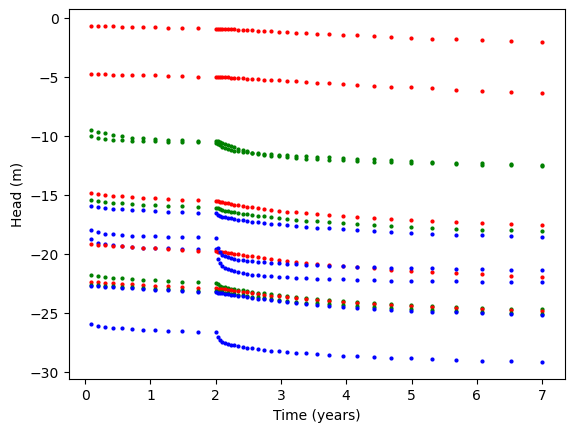

In [70]:
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

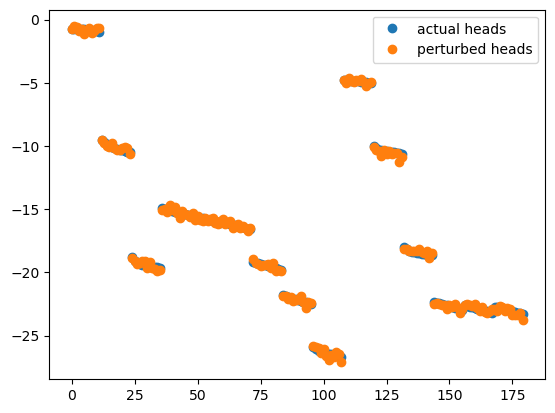

In [71]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.2
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', label = 'perturbed heads')
plt.legend()

### 15. Set up Markov Chain Monte Carlo (MCMC)

#### Define statistics of parameters

In [72]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
print(P.hk, P.vk)
print(logfunc(P.hk), logfunc(P.vk))

loop2flopy routines loaded!
[1.9042550670888736, 0.011369678375567143, 2.416734763867977, 0.05122383289450879] [0.2615533829558263, 0.0033458985841071966, 0.46292326427361563, 0.002290615307271618]
[ 0.279725 -1.944252  0.383229 -1.290528] [-0.58244  -2.475487 -0.334491 -2.640048]


In [73]:
#k_min = [-1, -3, -1, -3,   -3,  1, -2.5, -2]
#k_max = [1,   -1,  1,    -1, -0.5, -1, -0.5, -0.5]
#klist =[0.,-1.,0.69897,-1.,-1.,-2.,-0.30103,-2.] 
k_min = [0,-2,0,-2]
k_max = [1,-1,1,-1]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(4)]
"""plt.plot(np.linspace(0,7,8), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,7,8), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,7,8), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,7,8), logfunc(P.hk + P.vk), 'o', color = 'red')"""

"plt.plot(np.linspace(0,7,8), k_min, 'o', color = 'blue')\nplt.plot(np.linspace(0,7,8), k_max, 'o', color = 'blue')\nplt.plot(np.linspace(0,7,8), k_mean, 'o', color = 'orange')\nplt.plot(np.linspace(0,7,8), logfunc(P.hk + P.vk), 'o', color = 'red')"

In [74]:
def Likelihood(obs, mod, err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

#from DREAM import *
%run ../../Lab_tools/Uncertainty_tools/DREAM.py

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i])
    Width.append(k_mean[i] - k_min[i])
    Min.append(k_min[i]) 
    Max.append(k_max[i]) 

#make this anisotropy
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i]-1)
    Width.append(0.5)
    Min.append(k_min[i]-1) 
    Max.append(k_max[i]-1)
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(-4.5)
    Width.append(0.5)
    Min.append(-5) 
    Max.append(-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.125/2)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

#### Set up DREAM and define "run model" function

In [75]:
## DREAM for Steady State
err = 0.2
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 100 
minsamp = 169 # minimum number of samples

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

In [76]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = (['CP1', 'control', 3000, 3000, -100, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

In [77]:
def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp):
    print(loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp)
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
    P.sy = [sy0, 0.1, 0.1,0.1]#[sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)
    M.gwf, M.head_past, M.obs_past, M.runtime_past = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = process_obs_past(P, M)
    return(hobs_past, M)


In [78]:
#this function and argument statement are for the labtools dream implementation.

def L_func(Prop, P, hobs_ref, err):
    hmod, M = update_model(P,
                        Prop[0],
                        Prop[1],
                        Prop[2],
                        Prop[3],
                        Prop[4],
                        Prop[5],
                        Prop[6],
                        Prop[7],
                        Prop[8],
                        Prop[9],
                        Prop[10],
                        Prop[11],
                        Prop[12],
                        ) 
    a = np.array(hobs_ref) 
    b = np.array(hmod)
    P.hmod = hmod
    P.M = M
    return(Likelihood(a,b,err))
    
    
args = (P, hobs_ref, err,) # P - project object, hobs_ref - real observations, err - 
    
def result_func(Prop,P):
    M = P.M
    hpred = run_prediction(M, ic_array = M.head_past)
    overall = np.append(P.hmod,hpred,axis=2)
    #print(overall)
    return(overall)

Rfunc_args = (P,)
    

In [79]:
def run_prediction(M, ic_array):
    M.gwf, M.head_future, M.obs_future, M.runtime_future = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    hpred = process_obs_future(P, M)
    return hpred

In [ ]:
results = Dream_ZS(D,       # DREAM class being used.
                   L_func,  # function that recieves the proposed pars, places in model, runs model & returns Likelihood 
                   args,    # contains all the args for the model outside of the parameters
                   result_func = result_func,      # save the model outputs
                   result_func_args = Rfunc_args,  
                   minsamp = minsamp,         
                   print_freq = 1,
                   Test = False,      # If True, only initial likelihoods obtained
                   lookback = 10,
                   R_overide = False)  # Stops even if R=1.2 not reached

0.284699694219944 -1.9747812447444653 0.17302603477250045 -1.254931346674238 -0.7902458280283637 -2.5103576958828047 -0.17069699681623518 -2.073972427754151 -4.77975169766316 -4.543228804631267 -4.285023178749652 0.16330289691038558 -68.16248561546644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.312758
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  82.26195
Initial Likelihood for chain  0  =  -815704.5029042708
0.5663578513690006 -1.6746827341659194 0.5624477240777118 -1.3415784143881218 -0.27182838761018613 -2.4231846630178016 -0.3971826220039497 -2.3241129484828797 -4.004526866651366 -4.10731327340476 -4.56353806457595 0.12204937419046166 -200.8019621871356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  34.457097
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  96.413381
Initial Likelihood for chain  1  =  -57460.10295574801
0.9804937590254682 -1.6026145079749976 0.6671441232079389 -1.9970777997091766 -0.5652306079216017 -2.3353586370023725 -0.9079202411552245 -2.2089194920585995 -4.989033298594514 -4.448726843943794 -4.023051990776333 0.16857724769701302 -114.96987265665771
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281716
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  30.02902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.812546
Initial Likelihood for chain  2  =  -64976.076861637484
0.14073892902779472 -1.1750854422362078 0.6068938346532256 -1.6535302847389963 -0.403870254789352 -2.420423735684105 -0.6717770463039634 -2.7365514045238646 -4.636746160442794 -4.7841222213803345 -4.065261994497682 0.0971369843965663 -34.68574259255627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  32.264554
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  90.15008
Initial Likelihood for chain  3  =  -1373401.126592489
0.7019580227621934 -1.7861373438453896 0.5353045247739152 -1.647261260617548 -0.04062154583877331 -2.011342874868375 -0.6606713410582811 -2.4435503925398887 -4.921125290226273 -4.944198438018716 -4.627087531417836 0.1576493507547543 -34.09917090315102
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.218973
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.582695
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  61.325759
Initial Likelihood for chain  4  =  -177858.43665817214
0.2846987028445063 -1.9747732888215415 0.172985574373215 -1.560877359901474 -0.9271822400638658 -2.4693630558931146 -0.4091711128294931 -2.0739132412254726 -4.239290171983157 -4.70248530747509 -4.03277637541915 0.1850247483540041 -28.0909139852711
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.286031
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.052129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  83.124144
0.37171196169615844 -1.7629700992696704 0.3934948162541378 -1.3416524554299876 -0.621834423652786 -2.6560813777019057 -0.1684209491217897 -2.1516501496053437 -4.938481368029853 -4.920173288592479 -4.403932247553712 0.12467567530603514 -200.79967951401733
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.583141
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  35.565689
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  100.152159
0.043807114171542816 -1.6547754227940896 0.6544866958283194 -1.1398426033345141 -0.4573042458194379 -2.1431324289620113 -0.030791860288358563 -2.2645986668533227 -4.416671396894125 -4.839281914990319 -4.052544068470926 0.1851924334129472 -38.781407278702225
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.910481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.219108
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  91.016271
0.2078978777095967 -1.548378730436448 0.4045756885159649 -1.4675255610130689 -0.403783985743692 -2.4624495529940194 -0.43783818756972825 -2.4272985341258515 -4.636790395231751 -4.784192585685263 -4.167860574450578 0.12803211404201736 -50.464914861449685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.947772
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.463553
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.434828
0.7018791929002816 -1.7860747379428008 0.5353229361850519 -1.6473042988497257 -0.04055540809204123 -2.0113162901728807 -0.6606090769538229 -2.443580652254943 -4.921300506424346 -4.944320850129817 -4.627152838757811 0.15766489890835067 -34.114661808294635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.217794
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.504511
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.81458
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  1
sampled =   1.0  tried =  5.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -815704.5029042708
Current Likelihood for chain  1  =  -57460.10295574801
Current Likelihood for chain  2  =  -64976.076861637484
Current Likelihood for chain  3  =  -1069026.765199298
Current Likelihood for chain  4  =  -177858.43665817214
1
0.2847335563268553 -1.9747687263761577 0.17309902071216954 -1.5021224440874203 -0.8657490943087258 -2.5102813422691175 -0.38998755185073114 -2.0739575913015167 -4.944230896033527 -4.386713151825541 -4.284915047138139 0.1633038848534831 -97.63447543782932
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.667744
   Writing simulation and gwf for  run  ...
Period =  Steady 


Period =  Past 
   Model success =  True
   run_time =  85.122566
0.6963030412712269 -1.5889492284714273 0.624107016614291 -1.5049196347361817 -0.2717640054932812 -2.574453522269397 -0.3973472035394929 -2.3241076250984096 -4.004452885200531 -4.107296378933048 -4.281610860616224 0.12204029209525441 -200.8459213867805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  35.200044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  98.15602
0.9806089779758418 -1.6025239151117308 0.6671359107068996 -1.9970296327404002 -0.565055812553257 -2.335537329742377 -0.9079223304551592 -2.2088737941691194 -4.98892168664835 -4.448772590256646 -4.022927524396784 0.16856770642219615 -114.99891181792496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.398133
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  34.199585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  121.663181
0.20825976797973977 -1.54852832936032 0.4172038422174669 -1.3251096522899475 -0.4038005490695067 -2.462534103715605 -0.3147589487731522 -2.3715837294598456 -4.208981732205634 -4.393589466399349 -4.167770285376303 0.11142496634218836 -127.47202863066684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.403021
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  32.737179
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  86.648881
0.7019250130166157 -1.645974051141269 0.5353383954876546 -1.6473795040530246 -0.040759623651143335 -2.970611060565719 -0.6605720145859114 -2.560356547832398 -4.921194687488543 -4.944208792221765 -4.627013583107542 0.13839248227299045 -34.121476596123344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202038
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.416042
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  61.029204
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  2
sampled =   5.0  tried =  10.0
Currenty sampling at a rate of  50.0 %
Current Likelihood for chain  0  =  -815704.5029042708
Current Likelihood for chain  1  =  -38708.78324763455
Current Likelihood for chain  2  =  -64969.4784309058
Current Likelihood for chain  3  =  -707629.8896823399
Current Likelihood for chain  4  =  -173870.72654143677
2
0.2849703640555848 -1.955754072692466 0.1730733631261715 -1.2373597621363082 -0.7902467562508128 -2.4581881098591087 -0.17060075812773473 -2.1221011382704242 -4.780088126466114 -4.859335757101925 -4.285005889921879 0.16329687043392418 -68.12748587170064
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.148011
   Writing simulation and gwf for  run  ...
Period =  Steady 
 

Period =  Past 
   Model success =  True
   run_time =  86.798485
0.696516144261284 -1.5888911014710145 0.8265811324551686 -1.6909057691968372 -0.09151377696729686 -2.5324630740174205 -0.6313029576415092 -2.324086942640235 -4.937736219452467 -4.219834877611985 -4.179039933909428 0.09114177991430657 -200.83320212294078
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  41.477325
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  104.074652
0.11304490251876653 -1.6088697048087632 0.5927216797387452 -1.139951521521863 -0.7862240615775394 -2.243490893193792 -0.037117594923860686 -2.1551513089320853 -4.012772447869031 -4.555756969435905 -4.950019309310122 0.05470647928508847 -73.69658073250368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.573286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  83.333378
0.4365765883011926 -1.567482792975359 0.6143037977604577 -1.4294615326418407 -0.25782259458957707 -2.4625083951490923 -0.4051899705383715 -2.3235617839703187 -4.208907987222337 -4.130073769123252 -4.172943147268074 0.09419453173390409 -127.46582939346071
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170043
   Writing simulation and gwf for  run  ...


In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
gwf = sim.get_model('run')
print("minimum cell thickness = %f at node %i" %(gwf.modelgrid.thick.min(), gwf.modelgrid.thick[node]))

In [ ]:
node = 8114-1

X = gwf.modelgrid.xyzcellcenters[0][node]
Y = gwf.modelgrid.xyzcellcenters[1][node]
Z = gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = gwf.modelgrid.xyzvertices[0][node]
yv = gwf.modelgrid.xyzvertices[1][node]
zv_top = gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, gwf, X=X, Y=Y, Z=Z)

In [ ]:
#dir(P.M)
len(results)#[0][0][0]) #260,5,3,42

In [ ]:
for i in range(nchains):
    plt.plot(D.chains[i].likelihood)
plt.xlim(nburn,)
plt.ylim(-2500,0)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((minsamp-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0, minsamp),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [ 0.00005, 0.00005, 0.00005]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [ ]:
# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

times = times_past.tolist() + [i +2 for i in times_future.tolist()]

In [ ]:
# Load REFERENCE results
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

# Load DREAM results
fname = '../results/dream_results.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

### Plot reality vs predicted

In [ ]:
# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

In [ ]:
fig = plt.figure(figsize=(3,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(dream_results)): 
            ax.plot(times, dream_results[i, j, k], '-', color = colors[k], alpha = 0.6, lw = 0.1 ) 
        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = 'black')#colors[k]) # Plot truth
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""